In [73]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import scipy.signal as signal
import scipy
from tqdm import tqdm
from scipy.io.wavfile import write
from scipy import stats

sys.path.insert(0, '/home/leo_dacasi/Dokumente/summerofcode/ENFify/sources')
from ENF_preprocessing import downsampling, bandpass_filter, cut_tones
from ENF_frequency_phase_estimation import segmented_phase_estimation_DFT0, segmented_phase_estimation_DFT1, segmented_phase_estimation_hilbert
from Rodriguez_Audio_Authenticity import find_cut_in_phases


In [74]:
def func_ENF_synthesis_corrupted_harmonic(fundamental_f, harmonic_index, corrupted_index, duration, fs, corrupt):
    N = int(duration * fs)
    
    # Create fundamental IF
    f0 = np.random.randn(N)
    IF0 = np.cumsum(f0) * 0.0005
    IF0 = IF0 / np.std(IF0) * np.sqrt(4.5e-4)
    IF0 = IF0 + fundamental_f
    IFs = np.outer(harmonic_index, IF0)  # IFs across all harmonics
    
    if corrupt == True:
        index = np.intersect1d(harmonic_index, corrupted_index) - 1
        for i in range(len(index)):
            IFs[index[i], :] = IFs[index[i], :] + 5 * np.random.randn(N)

    # Instantaneous amplitudes and initial phases
    N_harmonic = len(harmonic_index)
    amps = 1 + np.random.randn(N_harmonic, N) * 0.005  # instantaneous amplitudes
    phases = np.random.uniform(0, 2 * np.pi, N_harmonic)  # initial phases

    # Synthesize time domain waveforms
    ENF_multi = np.zeros((N_harmonic, N))
    for n in tqdm(range(N)):
        ENF_multi[:, n] = amps[:, n] * np.cos(2 * np.pi / fs * np.sum(IFs[:, :n+1], axis=1) + phases)
    
    for i in range(min(6, N_harmonic)):
        ENF_multi[i, :] = ENF_multi[i, :] / np.linalg.norm(ENF_multi[i, :])

    raw_wave = np.sum(ENF_multi, axis=0)
    raw_wave_multi = ENF_multi
    raw_wave = raw_wave / np.linalg.norm(raw_wave)  # ensure unit norm

    return raw_wave, IF0, raw_wave_multi

def bandpass_filter(sig,lowcut, highcut, fs, order):
    
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = signal.butter(order, [low, high], btype='band', output='sos')
    bandpass_sig = signal.sosfiltfilt(sos, sig)

    return bandpass_sig

def butter_bandpass_test(lowcut, highcut, fs, order=5, label=None):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = signal.butter(order, [low, high], btype='band', output='sos')
    w, h = signal.sosfreqz(sos,worN=20000)
    plt.semilogx((fs * 0.5 / np.pi) * w, abs(h), label=label)
    return sos

  0%|          | 0/60000 [00:00<?, ?it/s]

100%|██████████| 60000/60000 [00:02<00:00, 29577.38it/s] 


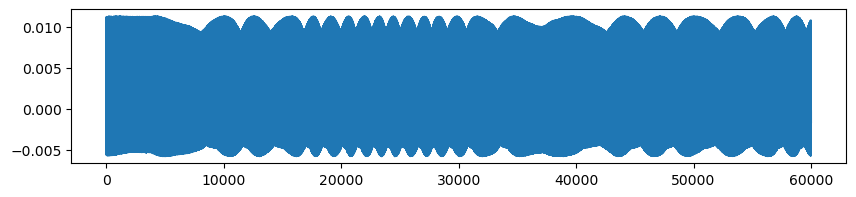

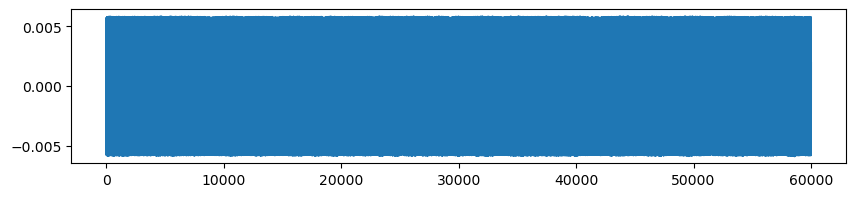

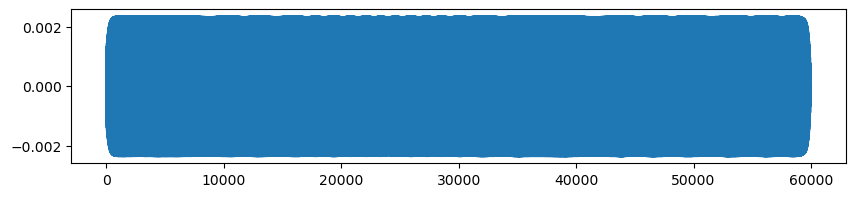

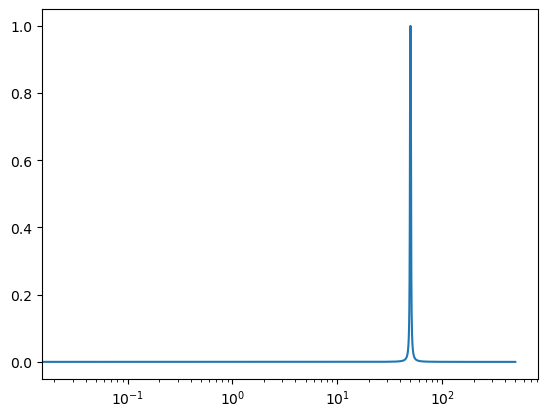

In [32]:
# Example
fundamental_f = 50  # ENF freq
harmonic_index = np.array([1, 2, 3, 4, 5, 6])
corrupted_index = np.array([2, 4, 6])
duration = 60  # in seconds
fs = 1000  # sampling frew

raw_wave, IF, raw_wave_multi = func_ENF_synthesis_corrupted_harmonic(fundamental_f, harmonic_index, corrupted_index, duration, fs, False)

plt.figure(figsize=(10,2))
plt.plot(raw_wave)
plt.show()

len(raw_wave_multi)
plt.figure(figsize=(10,2))
plt.plot(raw_wave_multi[0])
plt.show()

sig = bandpass_filter(raw_wave, 49.5, 50.5, fs, 1)

plt.figure(figsize=(10,2))
plt.plot(sig)
plt.show()

butter_test = butter_bandpass_test(49.5, 50.5, fs, order=2, label=None)

In [80]:
def find_cut_in_phases(phases, x):
    """_summary_

    Args:
        phases (_type_): _description_
        x (_type_): _description_

    Returns:
        _type_: _description_
    """
    second_der = np.gradient(np.gradient(phases, x), x)

    z_scores = np.abs(stats.zscore(second_der))
    ausreisser = np.array(np.where(z_scores > 10))

    if np.any(ausreisser) == False:
        return phases, x, ausreisser
    
    else: 
        print("Discontinuity")
        phases_new = phases[int(np.min(ausreisser)) - 200 : int(np.max(ausreisser)) + 200]
        x_new = x[int(np.min(ausreisser)) - 200 : int(np.max(ausreisser)) + 200]

        return phases_new, x_new, ausreisser

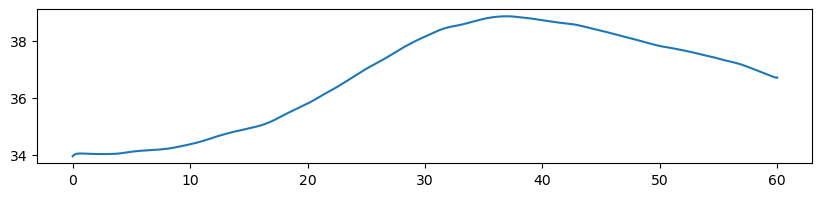

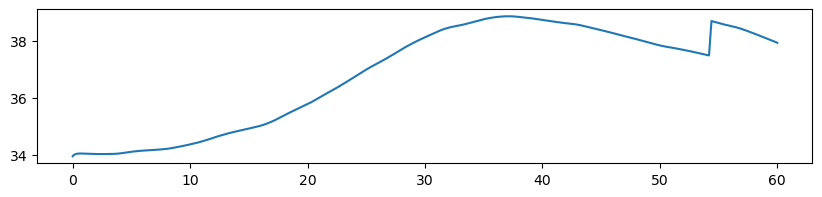

NameError: name 'stats' is not defined

In [81]:
NUM_CYCLES = 10 
ref_enf = 50
N_DFT = 20_000
fs = 1000
sig = bandpass_filter(raw_wave, 49.5, 50.5, fs, 1)

phases = segmented_phase_estimation_hilbert(sig, fs, NUM_CYCLES, ref_enf)
time = len(sig)/fs # time
x = np.linspace(0., time, len(phases))

plt.figure(figsize=(10,2))
plt.plot(x, phases)
plt.show()

cut_sig, cut_start, cut_len = cut_tones(sig, fs)
phases = segmented_phase_estimation_hilbert(cut_sig, fs, NUM_CYCLES, ref_enf)
time = len(sig)/fs # time
x = np.linspace(0., time, len(phases))

plt.figure(figsize=(10,2))
plt.plot(x, phases)
plt.show()

find_cut_in_phases(phases, x)

In [ ]:
def one_min_audio_alices(sig):
    